In [1]:
import pandas as pd

df = pd.read_csv('/scratch/ml9715/CLASSIFIER/train.csv')



In [2]:
path_to_image = df.iloc[0]['img_path_T1_mni152']

path_to_image

'/vast/by2026/BrainATLAS/segmentation_result/sub-ADNI035S7050_ses-M000_T1w/mri/fsaverage.T1.mni152.mgz'

In [ ]:
import nibabel as nib
import torch

# Load the .mgz file

img = nib.load(path_to_image)

# Get the data as a NumPy array
img_data = img.get_fdata()

# Convert the NumPy array to a PyTorch tensor
img_tensor = torch.from_numpy(img_data).float()

# Check the shape and type of the tensor
print(img_tensor.shape)
print(img_tensor.dtype)

torch.Size([197, 233, 189])
torch.float32


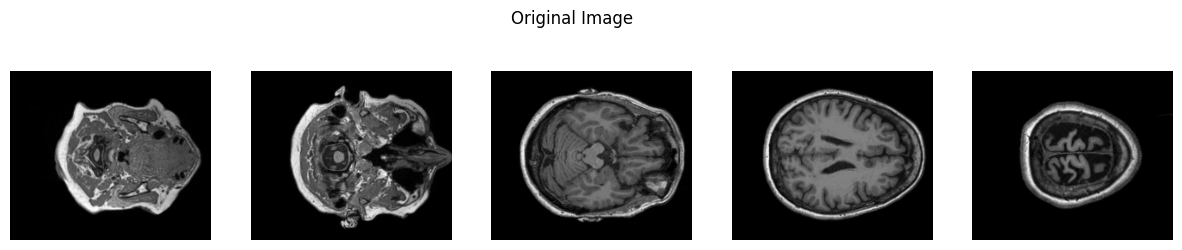

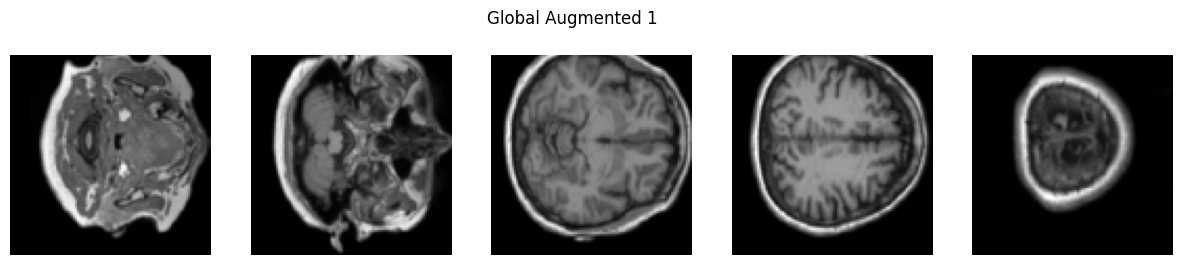

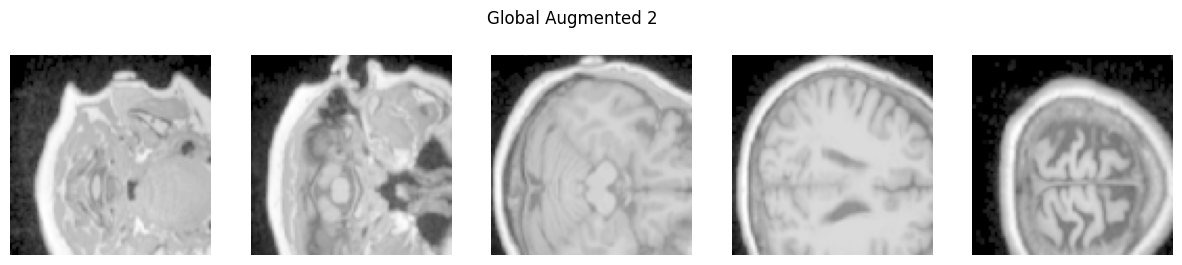

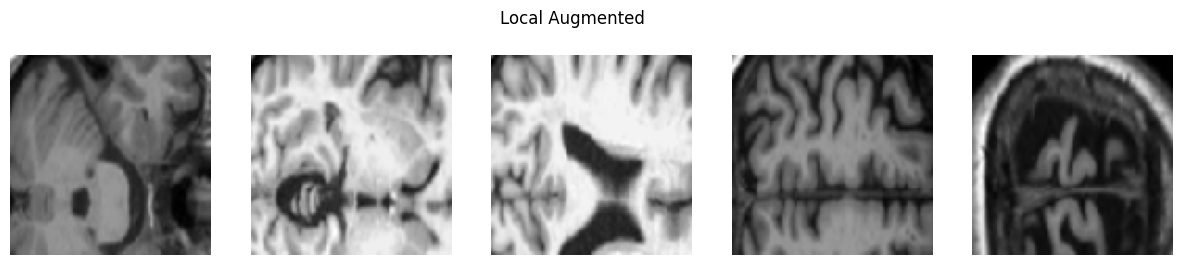

In [8]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import torch
from monai import transforms
from augmentations import DataAugmentationDINO3D

# Ensure img_tensor has a channel dimension and is float32
if img_tensor.dim() == 3:  # shape (H, W, D)
    img_tensor = img_tensor.unsqueeze(0)  # shape (1, H, W, D)
img_tensor = img_tensor.float()  # Ensure dtype is float32

augmentation = DataAugmentationDINO3D(
    final_size=(96, 96, 96),
    local_crops_size=(64, 64, 64),
    global_crops_size=(112, 112, 112),
    local_crops_number=2)

# Apply global transformations
global_augmented1 = augmentation.global_transfo1(img_tensor)
global_augmented2 = augmentation.global_transfo2(img_tensor)

# Apply local transformation
local_augmented = augmentation.local_transfo(img_tensor)

# Function to visualize a few slices from the 3D tensor
def visualize_slices(tensor, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        # Select slices from different depths
        slice_idx = tensor.shape[3] // 5 * i  # Select along depth
        ax.imshow(tensor[0, :, :, slice_idx].cpu().numpy(), cmap="gray")
        ax.axis("off")
    plt.show()

# Visualize the original tensor and the augmented versions
visualize_slices(img_tensor, "Original Image")
visualize_slices(global_augmented1, "Global Augmented 1")
visualize_slices(global_augmented2, "Global Augmented 2")
visualize_slices(local_augmented, "Local Augmented")


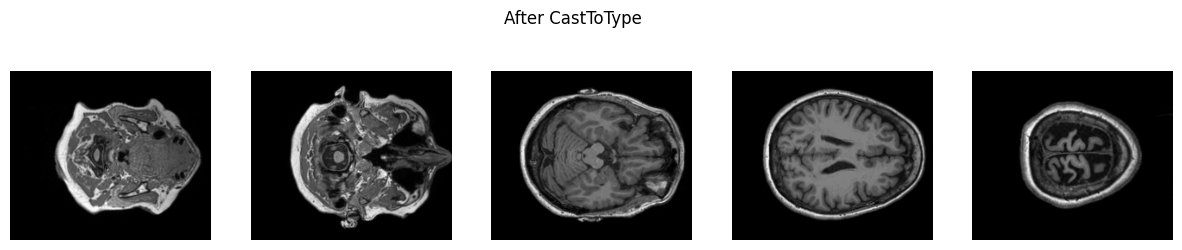

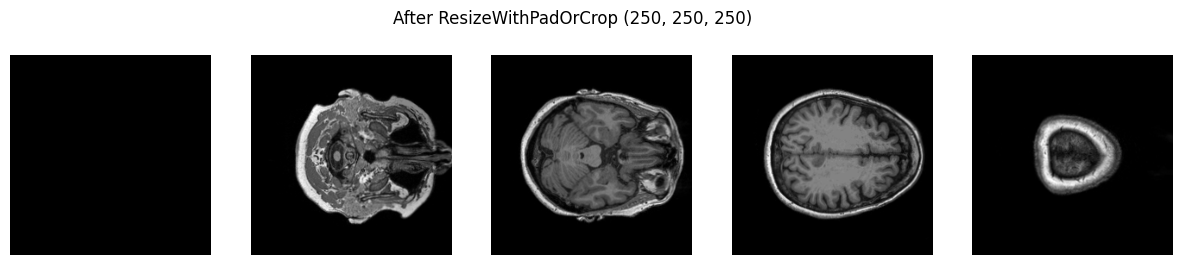

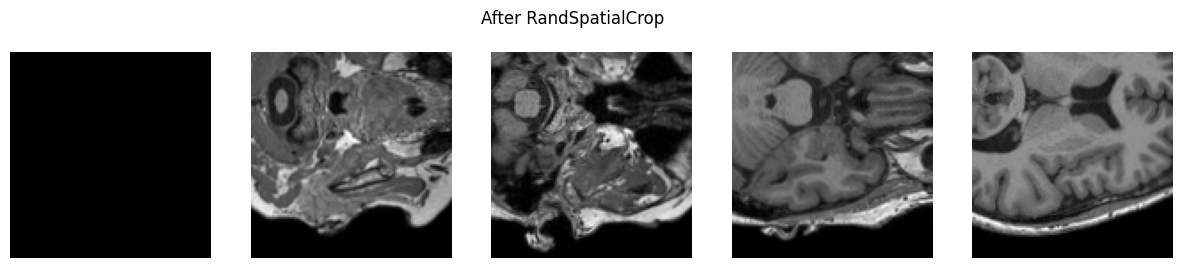

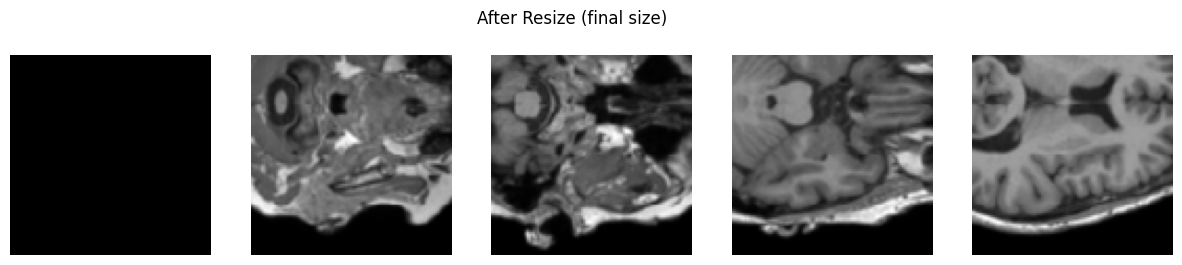

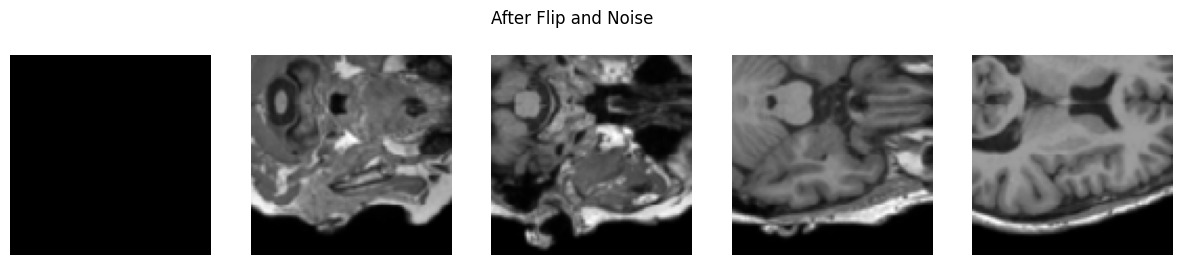

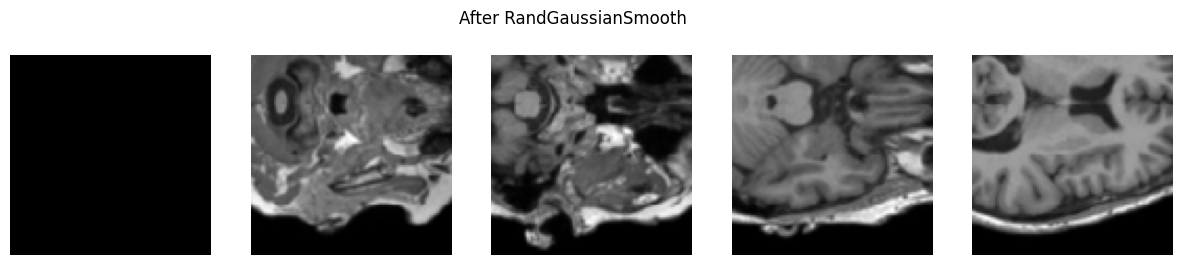

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from monai import transforms
from augmentations import DataAugmentationDINO3D

final_size=(96, 96, 96)
local_crops_size=(64, 64, 64)
global_crops_size=(112, 112, 112)
max_global_crops_size = (144, 144, 144)
local_crops_number=2
# Define the transformations
cast_to_type = transforms.CastToType(dtype=np.float32)
resize_with_pad_or_crop = transforms.ResizeWithPadOrCrop(spatial_size=(233, 233, 233))
rand_spatial_crop = transforms.RandSpatialCrop(global_crops_size, max_global_crops_size, random_center=True, random_size=True)
resize_final = transforms.Resize(spatial_size=final_size)
flip_and_noise = transforms.Compose([
    transforms.RandFlip(prob=0.2, spatial_axis=0), 
    transforms.RandFlip(prob=0.2, spatial_axis=1), 
    transforms.RandFlip(prob=0.2, spatial_axis=2), 
    transforms.RandShiftIntensity(offsets=0.2, prob=0.5)
])
rand_gaussian_smooth = transforms.RandGaussianSmooth(sigma_x=(0.5, 1.0), sigma_y=(0.5, 1.0), sigma_z=(0.5, 1.0), prob=0.2)
normalize = transforms.ToTensor()

# Function to visualize slices of a 3D tensor
def visualize_slices(tensor, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title)
    for i, ax in enumerate(axes):
        # Select slices from different depths
        slice_idx = tensor.shape[3] // 5 * i
        ax.imshow(tensor[0, :, :, slice_idx].cpu().numpy(), cmap="gray")
        ax.axis("off")
    plt.show()

# Ensure img_tensor has a channel dimension and is float32
if img_tensor.dim() == 3:  # shape (H, W, D)
    img_tensor = img_tensor.unsqueeze(0)  # shape (1, H, W, D)
img_tensor = img_tensor.float()  # Ensure dtype is float32

# Apply and visualize each transform step-by-step
transformed_tensor = cast_to_type(img_tensor)
visualize_slices(transformed_tensor, "After CastToType")

transformed_tensor = resize_with_pad_or_crop(transformed_tensor)
visualize_slices(transformed_tensor, "After ResizeWithPadOrCrop ")

transformed_tensor = rand_spatial_crop(transformed_tensor)
visualize_slices(transformed_tensor, "After RandSpatialCrop")

transformed_tensor = resize_final(transformed_tensor)
visualize_slices(transformed_tensor, "After Resize (final size)")

transformed_tensor = flip_and_noise(transformed_tensor)
visualize_slices(transformed_tensor, "After Flip and Noise")

transformed_tensor = rand_gaussian_smooth(transformed_tensor)
visualize_slices(transformed_tensor, "After RandGaussianSmooth")


